# Inferring from Weather data

In this homework, we are going back to Weather data again. The main task of the homework is to do the spectral analysis of TAVG measurements in India.

In [1]:
country = 'India'
meas = 'TAVG'

## Part 0: Loading libraries and data

In [2]:
%pylab inline

import pandas as pd
import numpy as np

from lib.numpy_pack import unpackArray, unpackAndScale
from lib.YearPlotter import YearPlotter
from lib.decomposer import decompose_dataframe, Eigen_decomp
from lib.Reconstruction_plots import plot_recon_grid, recon_plot

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [4]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [5]:
## load measurement and stations dataframe
parquet_root = './resource/asnlib/publicdata/'

weather_path = os.path.join(parquet_root, 'weather-{}-{}.parquet'.format(country, meas))
weather = sqlContext.read.parquet(weather_path)
sqlContext.registerDataFrameAsTable(weather, 'weather')
print('weather is a Dataframe (and table) which is a join of measurements and stations with %d records'%(weather.count()))

weather is a Dataframe (and table) which is a join of measurements and stations with 4811 records


In [6]:
import pickle 

ms = []
pkl_filename = os.path.join(parquet_root, "%s-TMAX,TMIN,TAVG.pkl"%(country))
with open(pkl_filename,'br') as pkl_file:
    STAT = pickle.load(pkl_file)

## Part 1: Exploring the PCA decomposition

In this section, we want to construct approximations of TAVG measurements in India using the mean and the 2 top eigenvectors. **Each TAVG measurement is a list of average temperature values measured in a weather station for all days (366 days) in a year.**

- `EigVec` is a matrix of shape (366, 2), in which each column is an eigenvector of all the TAVG measurements in India.
- `Mean` is a vector of length 366 that has the average TAVG measurements across all stations in India. 

In [7]:
k = 2
EigVec = np.array(STAT[meas]['eigvec'][:,:k])
Mean = STAT[meas]['Mean']

First we want to plot the mean and the 2 top eigenvectors as functions of time (days of a year).

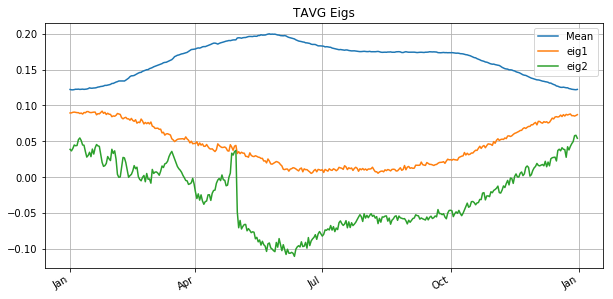

In [8]:
_norm_Mean = Mean / max(Mean) * 0.2 # Combine mean with Eigvecs and scale to similar range.
A = [_norm_Mean] + [EigVec[:,i] for i in range(EigVec.shape[1])]
Combined = np.stack(A).transpose()
fig, axes = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5)); 

YearPlotter().plot(Combined, fig, axes, title=meas+' Eigs', labels=['Mean'] + ['eig'+str(i+1) for i in range(k)])

### Problem 1

Given that all the eigenvalues are stored in `eigvals`, plot the percentage of the variance explained by the first 9 eigenvectors. The resulting graph should look like this:
![Problem 1](figs/prob1.png "Percentage of variance explained")
Note that the graph shows **10** points instead of 9, since it includes the percentage of the variance explained by 0 eigenvector.

#### Task:

Calculate the numpy array `cumvar_10`.The element of `cumvar_10` on index $i$ is the percentage of the variance explained by the first $i$ eigenvectors. **Note that each value in `cumvar_10` should be a value from 0 to 100.** Check the correctness of your solution by comparing your graph with the graph shown above. 

You may ignore the fact that some eigenvalues are negative, which may be caused by the numerical errors induced by nan values. You should just treat them as normal eigenvalues and should NOT manually make them positive. Also, you don't have to sort `eigvals` as the first 10 values in `eigvals` are already sorted according to their magnitude. 

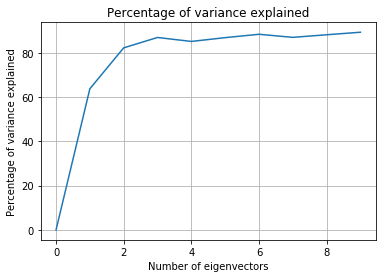

In [9]:
eigvals = STAT[meas]['eigval']

###
### YOUR CODE HERE
###

cumvar_10 = np.insert(eigvals[:9].cumsum() / eigvals.sum() * 100, 0, 0)

cumvar_10 = np.array(cumvar_10)
fig,ax=plt.subplots(1,1);
ax.plot(cumvar_10); 
ax.grid(); 
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of eigenvectors')
ax.set_title('Percentage of variance explained');

In [10]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Here we construct a Spark DataFrame `df2`, in which each row is a TAVG measurement from a weather station in India. We will be focusing on these columns of `df2` in this notebook:

- `Values`: the TAVG temperature measurement, which is a list of the average temperatures for 366 days in a year (encoded in a byte array).
- `coeff_[i]`: the projection coefficient in front of the `[i]`th eigenvector in the eigen-decomposition of `Values`.
- `res_[i]`: the normalized residual norm of the approximation using the top `[i]` eigenvector.
- `Station`: the id of the station from which the measurement was collected.
- `latitude`, `longitude`: the latitude and longitude of the station.

In [11]:
Query="""
select *
from weather
WHERE country='%s' and measurement='%s'
""" % (country, meas)
df = sqlContext.sql(Query)

df2 = decompose_dataframe(sqlContext, df, EigVec, Mean).cache()
df2.toPandas().head()

,Measurement,Station,Values,Year,coeff_1,coeff_2,country,dist2coast,elevation,latitude,longitude,name,res_1,res_2,res_mean,state,total_var
0,TAVG,IN017121000,"[184, 0, 187, 0, 181, 0, 207, 0, 203, 0, 187, ...",2020,131.490175,-95.774324,India,286.25,230.0,21.917,84.083,JHARSUGUDA,0.900244,0.847321,0.006377,,27177476.0
1,TAVG,IN024059900,"[25, 252, 25, 252, 25, 252, 25, 252, 25, 252, ...",2020,6.822229,-15.822153,India,487.75,131.0,26.633,88.317,SILIGURI,0.997147,0.984403,0.004200,,7588012.0
2,TAVG,IN008040500,"[97, 0, 115, 0, 124, 0, 120, 0, 104, 0, 103, 0...",2020,-1002.484684,-187.368935,India,1127.00,367.0,32.667,74.833,JAMMU,0.185366,0.156908,0.061604,,20025644.0
3,TAVG,IN023420800,"[39, 0, 17, 0, 32, 0, 17, 0, 29, 0, 38, 0, 25,...",2020,-1764.473492,881.425849,India,1045.00,2311.0,29.467,79.650,MUKTESHWAR KUMAON,0.274541,0.113426,0.507652,,9150026.0
4,TAVG,IN006031000,"[123, 0, 144, 0, 81, 0, 104, 0, 135, 0, 131, 0...",2019,-755.542637,-500.901593,India,817.00,221.0,29.167,75.733,HISSAR,0.458276,0.216608,0.044107,,24094505.0


In [12]:
## Visualize columns in df2
#df2.columns

Then we will study what information `coeff_1` and `coeff_2` can tell us.

For each coefficient, 

1. We first filter out the rows where the approximation residuals are too large.
1. Then we sort the rows according to the coefficient values in the increasing order.
1. Last we plot the rows that have the lowest and highest coefficient values. 

Each figure below plots the approximations of each measurement (each row in `df2`). 

- `mean`: the `Mean` variable.
- `target`: the `Values` field of the measurement. 
- `approx [i]`: the approximation using the first `[i]` eigenvectors. 
- `c[i]`, `r[i]`: the values of `coeff_[i]`, `res_[i]`.

In [13]:
# Filter and sort according to coeff_1
coeff1_rows = df2.filter(df2.res_1 < 0.3).sort(df2.coeff_1).collect()

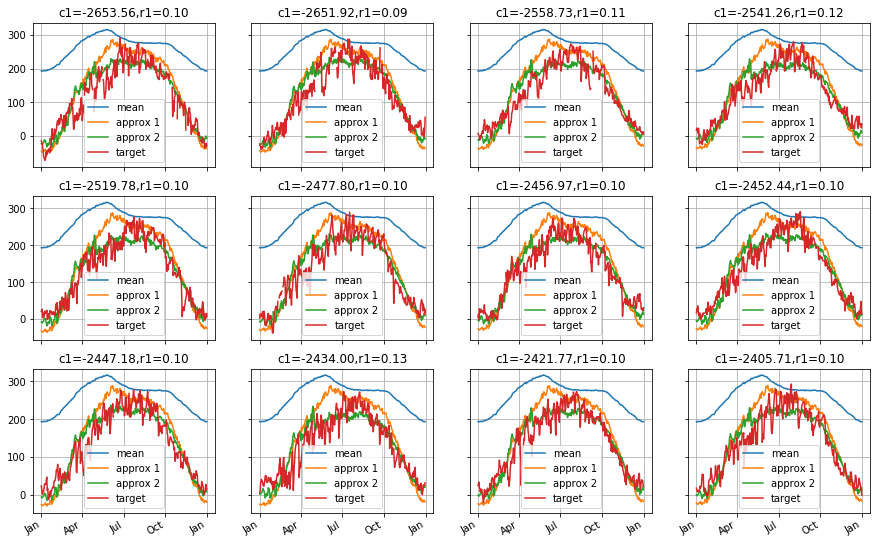

In [14]:
# Measurements with lowest 12 coeff_1
plot_recon_grid(coeff1_rows[0:12], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

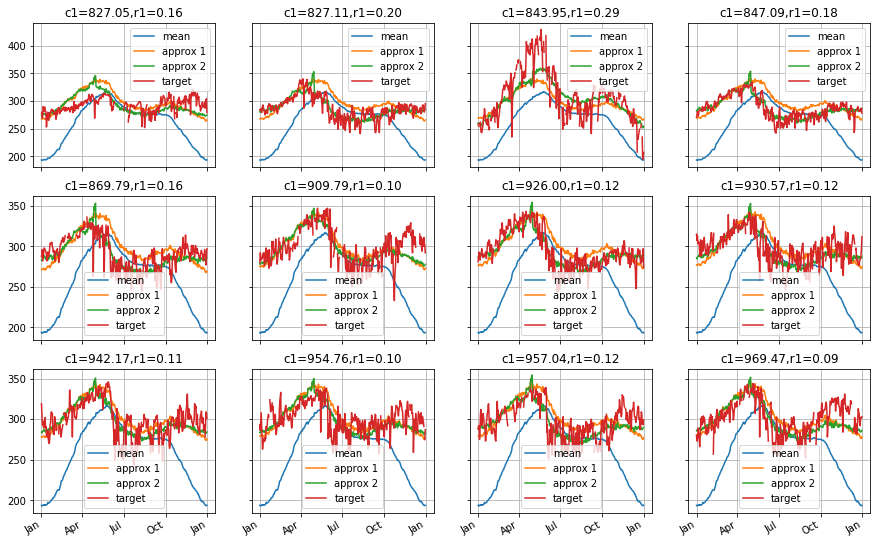

In [15]:
# Measurements with highest 12 coeff_1
plot_recon_grid(coeff1_rows[-12:], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

### Problem 2

The following problems ask you to derive information from the 2 figures shown above. You should be able to answer these questions just by looking at the figures. 


#### Task:

Answer the 4 questions below. Put your answers into the corresponding variables in the next cell.

1. (`answer2_1`) What is the month with the highest average temperature over all stations?

    1. February 
    
    1. Apil
    
    1. June
    
    1. August
    
    1. October
    
1. (`answer2_2`) What are the three months with almost the same average temperature over all stations?

    1. January, February, and March
    
    1. Apirl, Augest, and Septermper
    
    1. March, November, and December
    
    1. January, June, and December
    
1. (`answer2_3`) What is the relation between the value of the first coefficient (`c1`) and the value of averaging the TAVG (`target`) over the year?

    1. Correlated
    
    1. Anticorrelated
    
    1. Uncorrelated
    
1. (`answer2_4`) What is the relation between the value of the first coefficient (`c1`) and the absolute difference of the TAVG (`target`) between winter and summer?

    1. Correlated
    
    1. Anticorrelated
    
    1. Uncorrelated
    
    
**Hint:**

- We say two quantities are correlated when one quantity increases (decreases) and the other increases (decreases).
- We say two quantities are anticorrelated when one quantity increases (decreases) and the other decreases (increases).
- We say two quantities are uncorrelated when there is no obvious relation between them.

In [16]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
answer2_1 = 'A'
answer2_2 = 'B'
answer2_3 = 'C'
answer2_4 = 'D'

###
### YOUR CODE HERE
###

answer2_1 = 'C'
answer2_2 = 'B'
answer2_3 = 'A'
answer2_4 = 'B'

In [17]:
answers = ['A', 'B', 'C', 'D', 'E']
assert answer2_1 in answers, 'answer2_1 should be one of {}'.format(answers)

answers = ['A', 'B', 'C', 'D']
assert answer2_2 in answers, 'answer2_2 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer2_3 in answers, 'answer2_3 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer2_4 in answers, 'answer2_4 should be one of {}'.format(answers)

In [18]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [19]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [20]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [21]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [22]:
# Filter and sort according to coeff_2
coeff2_rows = df2.filter(df2.res_2 < 0.11).filter(df2.res_1 > 0.2).sort(df2.coeff_2).collect()

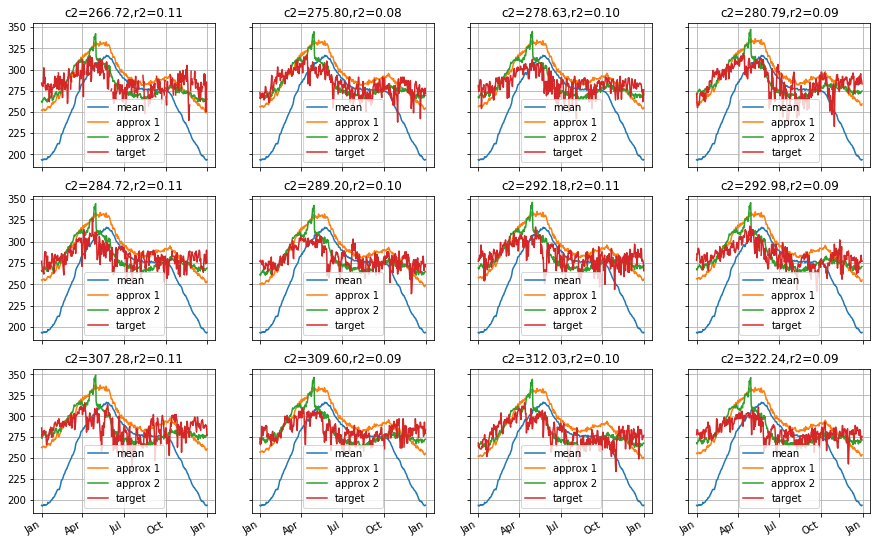

In [23]:
# Measurements with lowest 12 coeff_2
plot_recon_grid(coeff2_rows[0:12], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

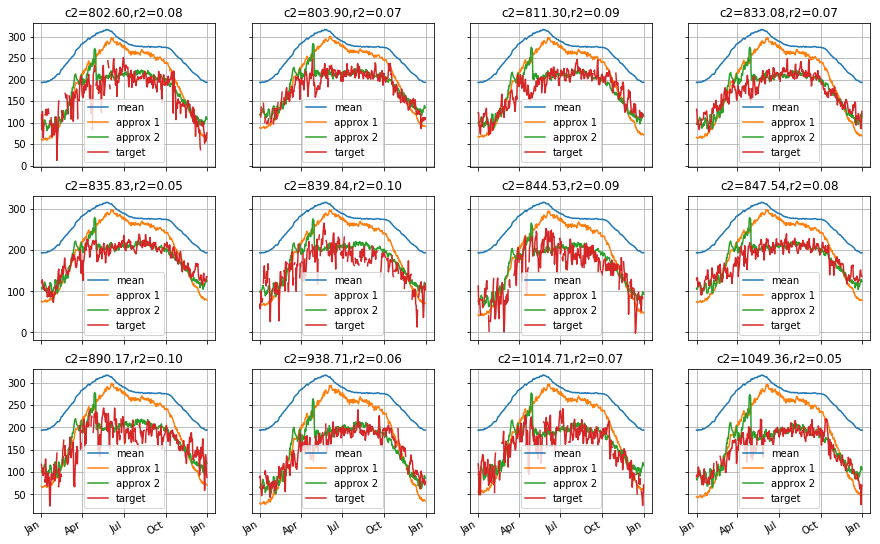

In [24]:
# Measurements with highest 12 coeff_2
plot_recon_grid(coeff2_rows[-12:], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

### Problem 3

The following problems ask you to derive information from the 2 figures shown above. You should be able to answer these questions just by looking at the figures. 

#### Task:

Answer the 2 questions below. Put your answers into the corresponding variables in the next cell.

1. (`answer3_1`) What is the relation between the winter temperature and the summer temperature when coefficient 2 (`c2`) is > 800?

    1. The winter temperature is usually higher than the summer temperature
    
    1. The winter temperature is usually lower than the summer temperature
    
    1. The winter temperature is usually similar to the summer temperature
    
1. (`answer3_2`) What is the relation between the winter temperature and the summer temperature when coefficient 2 (`c2`) is < 350?

    1. The winter temperature is usually higher than the summer temperature
    
    1. The winter temperature is usually lower than the summer temperature
    
    1. The winter temperature is usually similar to the summer temperature

In [25]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
answer3_1 = 'A'
answer3_2 = 'B'

###
### YOUR CODE HERE
###


answer3_1 = 'B'
answer3_2 = 'C'

In [26]:
answers = ['A', 'B', 'C']
assert answer3_1 in answers, 'answer3_1 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer3_2 in answers, 'answer3_2 should be one of {}'.format(answers)

In [27]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [28]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Instead of plotting the measurements with lowest and highest coefficients, we can just visualize any measurement and its approximations in an interactive plot, where the different approximations can be seen by manually changing the projection coefficients.

In [29]:
# Here we select the measurement (row) with highest `coeff_2`.
row = coeff2_rows[-1]

target = np.array(unpackArray(row.Values, np.int16), dtype=np.float64)
eigen_decomp = Eigen_decomp(None, target, Mean, EigVec)
total_var, residuals, coeff = eigen_decomp.compute_var_explained()
res = residuals[1]
print('residual normalized norm  after mean:', res[0])
print('residual normalized norm  after mean + top eigs:', res[:])

plotter = recon_plot(eigen_decomp, year_axis=True, interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.48807580115566984
residual normalized norm  after mean + top eigs: [0.4880758  0.30144218 0.05103543]


VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=0.0, min=-1664.5074436452255, orientation='vertical', step=166.45074436452256), FloatSlider(value=0.0, description='c1', max=1049.361487524602, orientation='vertical', step=104.93614875246018))), Output()))

### Problem 4

The following problem asks you to play with the interactive plot to see what will happen. You should be able to answer these questions just by changing the sliders for `c0` and `c1`. 

#### Task:

Answer the question below. Put your answers into the corresponding variables in the next cell.

1. What are the values of `c0` and `c1` that can recreate the graph shown below?

![Problem 4](figs/prob4.png "Expected graph for Problem 4")

In [30]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
c0 = 100.0
c1 = 200.0

###
### YOUR CODE HERE
###

c0 = -998.70
c1 = 944.43

In [31]:
assert type(c0) == float, 'c0 should be a float number'
assert type(c1) == float, 'c1 should be a float number'

In [32]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [33]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


## Part 2: Partitioning the `coeff_1`, `coeff_2` plane 

If we view `coeff_1` as the x-axis and `coeff_2` as the y-axis, we can find that the distribution of the coefficients of the first 2 eigenvectors in `df2` shows some clusters. In this section, we will analyze the coefficients by grouping them together.

First, we define 7 clusters and manually choose the centers for these clusters. In each center, the first element defines the center for `coeff_1` and the second element defines the center for `coeff_2`. 

In [30]:
centers = {
    '0': (0, 0),
    '1': (-250, -250),
    '2': (500, 0),
    '3': (500, 400),
    '4': (-100, 600),
    '5': (-1500, 500),
    '6': (-200, 100)
}

C = []
for key in centers:     
    C.append(centers[key])
C = stack(C)

### Problem 5

Here we are doing several things that are useful later:

1. Convert `df2` to `df3` by grouping the measurements that are from the same `Station`. Each row of `df3` is a station with its `Station`, `Longitude`, `Latitude` and average values of `coeff_1`, and `coeff_2` of the measurements from the station.
1. Count the number of measurements for each `Station` and store the results in `station_counts`.
1. Get `pdf` by merging (join) `df3` and `station_counts` on column `Station`.

Note that `pdf` is a pandas DataFrame instead of Spark DataFrame to allow less constrained queries.

#### Task:

Write the code that converts `df2` to `df3` (first point above). 
- The `coeff_1` and `coeff_2` columns are grouped by taking the average.
- The `Longitude` and `Latitude` columns are grouped by taking the average or selecting any of them since the same `Station` will have the same `Longitude` and `Latitude`.
- The rest of the columns in `df2` are discarded.
- `df3` should have 5 columns: `Station`, `coeff_1`, `coeff_2`, `Longitude`, and `Latitude`. Although your solution doesn't have to have the exact same column names, **you should have the same column order** (1st column is stations, 2nd column and 3rd column are the average coeff_1 and coeff_2 values, and 4th and 5th columns are longitudes and latitudes.) 
- The order of the rows in `df3` doesn't matter.
- You should use Spark DataFrame API instead of pandas DataFrame API for this task.

Hints:
1. Use [`groupBy`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.groupBy.html).

In [31]:
###
### YOUR CODE HERE
###

# Create df3 
df3 = (df2
       .groupBy(['Station'])
       .mean('coeff_1', 'coeff_2', 'Longitude', 'Latitude')
      )
print(df3.columns)

pdf3 = df3.toPandas().sort_values('Station')
station_counts = df2.groupBy('Station').count()
pdf = pdf3.merge(station_counts.toPandas(), on='Station')
print(f'There are in total {pdf.shape[0]} stations')

# Assign shorter names to the columns
pdf.columns=['Station', 'coeff_1', 'coeff_2', 'Longitude', 'Latitude', 'count']
pdf.head()

['Station', 'avg(coeff_1)', 'avg(coeff_2)', 'avg(Longitude)', 'avg(Latitude)']
There are in total 183 stations


,Station,coeff_1,coeff_2,Longitude,Latitude,count
0,IN001020700,501.828895,56.073761,77.633,14.583,52
1,IN001050200,440.247446,-10.410478,82.233,16.950,50
2,IN001080500,269.624439,135.317346,78.470,17.450,54
3,IN001090500,318.556718,-95.619204,79.433,18.767,49
4,IN001111200,428.893895,-43.875230,81.150,16.200,50


In [ ]:
test = df3.toPandas().sort_values('Station').values
answer = np.array([
    ['IN001020700', 501.8288947351339, 56.073760669096956, 77.63299999999998, 14.583],
    ['IN001050200', 440.2474457975864, -10.410478399340107, 82.23299999999999, 16.95],
    ['IN001080500', 269.6244393741326, 135.31734576445672, 78.46999999999997, 17.450000000000006],
    ['IN001090500', 318.55671843948204, -95.6192036324071, 79.433, 18.767000000000003],
    ['IN001111200', 428.89389515464353, -43.875230463056795, 81.15000000000002, 16.200000000000003]
])


assert test.shape == (183, 5)
assert (test[:5, 0] == answer[:5, 0]).all(), 'Your answer is not correct'
assert np.isclose(test[:5, 1:].astype(float), answer[:5, 1:].astype(float), rtol=0, atol=1e-1).all(), 'Your answer is not correct'

In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 6

In this cell, we want to group the stations to their closest center that we defined earlier and add their groups to `pdf` DataFrame.

#### Task:

Given `coeffs`, in which each row contains the `(coeff_1, coeff_2)` of each station, find the index of centers in numpy array `C` that is closest (minimum euclidean distance) to the `(coeff_1, coeff_2)` of each station. Store the results in variable `group`, in which the value in index `i` is the index of the nearest center for `Station i` in `pdf`. 

Hints:
1. Use [`cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) to calculate the euclidean distance.
1. The best implementation should have only 2 lines of code. 
    1. Calculate the euclidean distances.
    1. Select the center with the minimized euclidean distance for each station.

In [32]:
from scipy.spatial.distance import cdist

coeffs = np.array(pdf[['coeff_1','coeff_2']])

###
### YOUR CODE HERE
###
group = cdist(coeffs, C).argmin(axis=1)

pdf['group'] = group
pdf.head()

,Station,coeff_1,coeff_2,Longitude,Latitude,count,group
0,IN001020700,501.828895,56.073761,77.633,14.583,52,2
1,IN001050200,440.247446,-10.410478,82.233,16.950,50,2
2,IN001080500,269.624439,135.317346,78.470,17.450,54,2
3,IN001090500,318.556718,-95.619204,79.433,18.767,49,2
4,IN001111200,428.893895,-43.875230,81.150,16.200,50,2


In [ ]:
answer = array([
    2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6,
])

assert (group[:22] == answer).all(), 'Your answer for the first 22 stations is not correct'

In [ ]:
answer = array([
    0, 0, 3, 2, 3, 1, 1
])

assert (group[-7:] == answer).all(), 'Your answer for the last 7 stations is not correct'

In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 7

Finally, we want to plot the scatter plot of all stations and their groups on the `coeff_1`-`coeff_2` plane.

In particular, each dot in the scatter plot represents a station and 

- The size of the dot indicates the number of measurements of the station (`count` column). 
- The color of the dot indicates the group to which the station belongs, which is determined by the index of the closest center.
    - 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'grey', 5: 'blue', 6: 'purple'
    
We also want to use text numbers to show the group numbers, which are positioned in the cluster center. 

#### Task:

Follow the steps below to use `pdf` to draw the plot described above.

1. Use [`pandas.DataFrame.plot.scatter`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html?highlight=example) to draw the scatters.
    - You need to figure out how to call this function and what parameters to pass for arguments `x`, `y`, and `s`. 
    - You need to figure out how to use the provided `cmap` for the argument `c`. `cmap` is a list of colors where the `cmap[i]` is the color for group i. **Having correct colors is very important as the questions latter rely heavily on this**.
    - Use `figsize=[15, 10]` as the parameter when calling this function to match the figure size.
1. Use [`matplotlib.pyplot.text`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.text.html), which is already loaded as the `text` function, and cluster centers `C` to draw the group number texts.
    - You need to figure out how to call this function, what parameters you need to pass for arguments `x`, `y`, and `s`, and how many times it is needed to be called.
    - Use `color='black'` and `size=20` as the parameters when calling this function to match the text colors and text size.

#### Hint:

Your plot should be the same as the one shown below, except that your plot should have colors.

![Problem 7](figs/prob7.png "Clusters of coeff_1 and coeff_2")

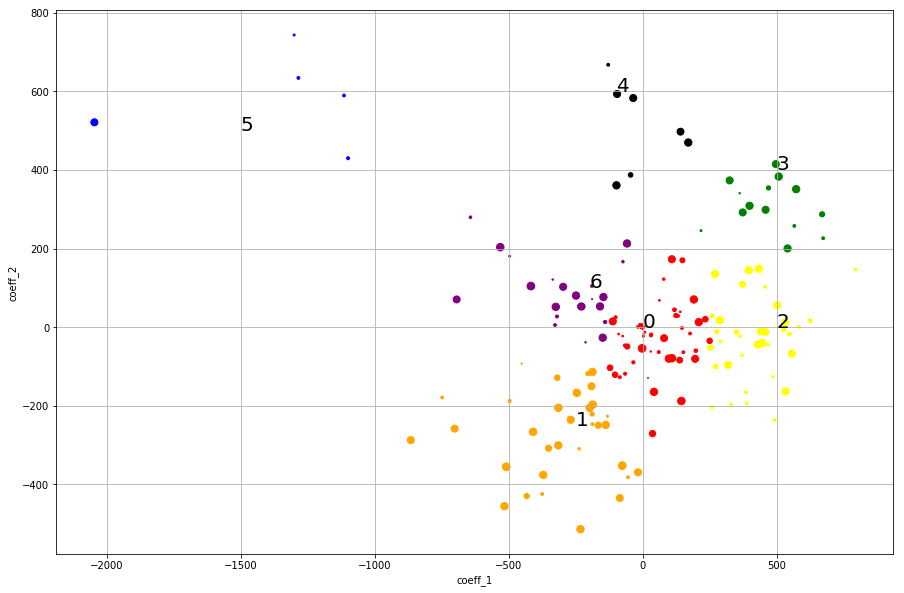

In [34]:
cmap = ['red', 'orange', 'yellow', 'green', 'black', 'blue', 'purple']

###
### YOUR CODE HERE
###

pdf.plot.scatter('coeff_1', 'coeff_2',
                 figsize=(15, 10),
                 c=pdf['group'].map(dict([i for i in enumerate(cmap)])), 
                 s=pdf['count'])

for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], str(i), color='black', size=20)

grid()

## Part 3: Visualizing the stations on the map

In this section, we will use [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) to visualize the data of `pdf` on an interactive map. 

### Problem 8

The interactive map is also a scatter plot with a real map as the coordinate system. 

- Again the color and the size of the circles represent the number of measurements from the station and the group that the station belongs to. 
- We want to add a blue rectangle to define the boundary of the stations that appeared on the map.
- The coordinate system used in the map is (latitude, longitude).


#### Task:

Follow the instructions below and fill in the blanks (`YOUR CODE HERE`) of the cell to recreate this map step by step. 

1. Step 1:
    1. Find the bounding box of the longitude and latitude in the `pdf` DataFrame
    2. Find the center `(latitude, longitude)` of the bounding box and store it in the `center` variable.
1. Step 2 (provided in the starter code):
    1. Construct the ipyleaflet `Map` object
1. Step 3:
    1. Construct the blue `Rectangle` object as the bounding box and add it to the map. 
        - You only need to use the `bounds` and `fill_opacity` parameters of `Rectangle`.
1. Step 4:
    1. For each row of the `pdf` DataFrame, add a `Circle` object to represent a station on the map. 
    Here are the instructions for the parameters of `Circle`.
        - Use `weight=1`,`opacity=0.7`, and `fill_opacity=0.7`.
        - Use $4800 \times \sqrt{count}$ for `radius`, where $count$ is the `count` of the station. 
        You might want to convert the result to an integer.
        - Use the list `cmap` and the group that the station belongs to determine the color for `fill_color` and `color`. **Again, having correct colors is very important as the questions later rely heavily on this**.
        - You need to figure out what is the value for `location` and you don't have to use other parameters.
1. Step 5 (provided in the starter code):
    1. Show the map


#### Hints:

Useful `ipyleaflet` APIs (note that the parameter documentation of the class that you are looking for might appear in its superclass): 
- [Rectangle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Rectangle)
- [Circle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Circle)
    
Your plot should be the same as the one shown below, except that your plot should have colors and is interactive. 

![Problem 8](figs/prob8.png "Map")

In [35]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps, basemap_to_tiles
)

# Step 1
###
### YOUR CODE HERE
###
bounds = [(pdf.Latitude.min(), pdf.Longitude.min()), (pdf.Latitude.max(), pdf.Longitude.max())]
center = pdf.Latitude.mean(), pdf.Longitude.mean(), 

# Step 2
zoom = 5
m = Map(basemap=basemaps.OpenStreetMap.HOT, default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# Step 3
###
### YOUR CODE HERE
###
rectangle = Rectangle(bounds=bounds, fill_opacity=0.)
m.add_layer(rectangle)

# Step 4
###
### YOUR CODE HERE
###
color = pdf['group'].map(dict([i for i in enumerate(cmap)]))

for i in range(pdf.shape[0]):
    circle = Circle(weight=1, opacity=0.7, fill_opacity=0.7)
    circle.location = (pdf.Latitude[i], pdf.Longitude[i])
    circle.radius = int(4800 * np.sqrt(pdf['count'][i]))
    circle.color = color[i]
    circle.fill_color = color[i]
    m.add_layer(circle)

# Step 5
m    

Map(basemap={'url': 'http://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>, Tiles courtesy of <a href="http://hot.openstreetmap.org/" target="_blank">Humanitarian OpenStreetMap Team</a>', 'name': 'OpenStreetMap.HOT'}, center=[21.663956284153006, 80.01991803278688], layers=(TileLayer(attribution='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>, Tiles courtesy of <a href="http://hot.openstreetmap.org/" target="_blank">Humanitarian OpenStreetMap Team</a>', base=True, max_zoom=19, min_zoom=1, name='OpenStreetMap.HOT', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size'], url='http://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png'), Rectangle(bounds=[(8.083, 68.85), (34.082999999999984, 95.617)], fill_opacity=0.0, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'no_clip', 'opacity', 'pointer_events', 'smooth_factor', 'stroke', 'weight']), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[14.583000000000007, 77.63300000000001], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=34613, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[16.949999999999996, 82.23299999999998], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33941, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[17.449999999999996, 78.47000000000001], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=35272, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[18.767, 79.433], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33600, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[16.199999999999996, 81.15000000000003], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33941, weight=1), Circle(color='red', fill_color='red', fill_opacity=0.7, location=[16.53300000000001, 80.79999999999998], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=26290, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[15.800000000000006, 78.067], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=32907, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[14.449999999999992, 79.98299999999998], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=34613, weight=1), Circle(color='yellow', fill_color='yellow', fill_opacity=0.7, location=[18.667, 78.10000000000001], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=14400,

## Part 4: Yearly temperature profile

Lastly, we want to plot the average TAVG measurements of each group as a function of the days in a year. To do this, we first need to construct a pandas DataFrame `profile` from `df2` that only has stations, decoded temperature values, and the group that the station belongs. Note that each row in `profile` is a measurement, so the names in `Stations` column are not unique.

In [ ]:
full_data = df2.rdd.map(lambda x: (x.Station, x.Year, unpackAndScale(x))).collect()
profile = pd.DataFrame({'Station':[f[0] for f in full_data], 'Values':[f[2] for f in full_data]})
profile = profile.merge(pdf[['Station', 'group']], on='Station')
profile.head()

Then we use data in `profile` DataFrame to plot the yearly temperature profiles (the average TAVG measurements of each group as the function of the days in a year). Here we hide the codes that we used to generate the profile graph on purpose, but the profile graph is shown below.
- We can see 7 waveforms in the graph, each of which corresponds to the yearly temperature profile of a group.
- Note that the colors used in the scatterplot/map and the profiles do **not** match.

![Problem 7](figs/prob9.png "Profile")

In [ ]:
## The hidden code to generate the profile graph. You can ignore this cell.
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 9

The following problem summarizes this homework. You are asked to relate different characterizations of the same group. To answer this question, you might want to go back to the visualization tools earlier in the notebook. 

In this notebook, we have characterized the clusters (groups) of the stations in 3 aspects: 
1. [A cluster in the scatterplot](#Problem-7).
    - group 0: 'red'
    - group 1: 'orange'
    - group 2: 'yellow'
    - group 3: 'green'
    - group 4: 'black'
    - group 5: 'blue'
    - group 6: 'purple'
1. [A geographical description of a region in India](#Problem-8) (One region is not described on purpose).
    - region A: Southern west coast
    - region B: Southern east coast
    - region C: New Delhi Area
    - region D: The area around Rajkot/Jamnagar
    - region E: Along the Brahmaputra river between Dibrugarh and Guwahati
    - region F: Mountain range in the south-west, between Bengaluru and Belagavi
1. [A yearly temperature profile](#Part-4:-Yearly-temperature-profile).
    - waveform a
    - waveform b
    - waveform c
    - waveform d
    - waveform e
    - waveform f
    - waveform g

#### Task:

Figure out 6 tuples of the form `(group, region, waveform)`, where the group, region, and waveform in each tuple are characterizing the same cluster (group). That is, figure out which `group` and which `waveform` each `region` corresponds to. Put your answers in 2 dictionaries below where the key is the `region` in uppercase letter and the value is your answer (number for `group` and lowercase letter for `waveform`). 

For example, the template provided in the cell below says that `(group 0, region 'A', waveform 'a')` are characterizing the same cluster (group), `(group 1, region 'B', waveform 'b')` are characterizing another cluster (group), and so on.

**You only need to give the answer (2 dictionaries). You don't have to include the codes that you used to get the answer, since we only grade on the correctness of your answer.**

#### Hints:

1. First figure out the relations between the groups in the scatterplot and the geographical descriptions.
    1. Find out the area on the `ipyleaflet` map based on the description.
    1. An area corresponds to a group in the scatterplot if they share the same color.
1. There are several ways that you can do to figure out which group each waveform of the yearly temperature profiles corresponds to.
    1. Plot the yearly temperature profile by yourself for each group using `profile` DataFrame and compare the shapes of waveforms in your plot and in the plot we showed.
    1. Decompose the yearly temperature profile vectors to get the first 2 coefficients. See where the coefficients are in the scatterplot and which group the coefficients are near to.

In [36]:
# THIS IS JUST A TEMPLATE. COPY THE DICTIONARIES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
group_answer = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
waveform_answer = {'A': 'a', 'B': 'b', 'C': 'c', 'D': 'd', 'E': 'e', 'F': 'f'}

###
### YOUR CODE HERE
###
group_answer = {'A': 3, 'B': 2, 'C': 1, 'D': 0, 'E': 6, 'F': 4}
waveform_answer = {'A': 'e', 'B': 'd', 'C': 'g', 'D': 'c', 'E': 'f', 'F': 'a'}

In [37]:
assert len(group_answer) == 6, 'group_answer should only have 6 keys/values'
assert len(waveform_answer) == 6, 'waveform_answer should only have 6 keys/values'

for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in group_answer, f'Your group_answer is missing region {region}'
for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in waveform_answer, f'Your waveform_answer is missing region {region}'

unique_group_answer = np.unique(list(group_answer.values()), return_counts=True)
unique_waveform_answer = np.unique(list(waveform_answer.values()), return_counts=True)
assert (unique_group_answer[1] == 1).all(), 'Your group_answer contains duplicate answers'
assert (unique_waveform_answer[1] == 1).all(), 'Your waveform_answer contains duplicate answers'

In [38]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [39]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [40]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [41]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [42]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [43]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [44]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [59]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###
